In [1]:
# Student Information
print("Students: Ibrahim Dodo, Orobosa Igho-Osagie")
print("Project Group 27")
print("PsyGenome-MentalHealth Dataset (PG-MHD)")
print("MSC AI & Machine Learning")
print("\n" + "="*60)
print("PROJECT: Binary Classification - Healthy vs. Unhealthy")
print("="*60)

Students: Ibrahim Dodo, Orobosa Igho-Osagie
Project Group 27
PsyGenome-MentalHealth Dataset (PG-MHD)
MSC AI & Machine Learning

PROJECT: Binary Classification - Healthy vs. Unhealthy


Psy# Mental Health Classification using Machine Learning

This notebook develops a machine learning pipeline for psychiatric classification using the PsyGenome Mental Health Dataset (PG-MHD) from Kaggle (https://www.kaggle.com/datasets/ziya07/psygenome-mentalhealth-dataset-pg-mhd). 
The dataset contains 500 individuals with multi-omics genomic features including SNPs, gene expression, and methylation data across four classes: Healthy, Bipolar Disorder, Schizophrenia, and Alzheimer's Disease.

The analysis consists of two parts. Part 1 transforms the data into a binary classification task (Healthy vs. Unhealthy) and trains models on imbalanced data (109 Healthy, 391 Unhealthy) using Variance Threshold and L1 Regularization for feature selection (83→51 features). Part 2 applies SMOTE to balance the classes (391 samples each) while maintaining identical feature selection, then compares performance. This design evaluates whether balancing techniques improve classification or if imbalanced models are superior for psychiatric genomic prediction.


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sklearn for Feature Selection (The Core Requirement)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Configuration
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# 1.2 Load Data
# Replace 'your_dataset.csv' with the actual path to your file
df = pd.read_csv('PsyGenome_MHD.csv') 

print(f"Original Shape: {df.shape}")
print("Original Class Distribution:")
print(df['Diagnosis'].value_counts())

# TARGET TRANSFORMATION (The Pivot to Binary)
# We map 'Healthy' to 0, and everything else (Bipolar, Alz, Schiz) to 1 (Unhealthy)
binary_map = {
    'Healthy': 0,
    'Bipolar Disorder': 1,
    "Alzheimer's": 1,
    'Schizophrenia': 1
}

df['Target'] = df['Diagnosis'].map(binary_map)

# Drop the original multi-class Diagnosis column and ID (not useful for prediction)
df_clean = df.drop(columns=['Diagnosis', 'Patient_ID'])

print("\nNew Binary Class Distribution:")
print(df_clean['Target'].value_counts())
# You should see ~391 Unhealthy (1) and ~109 Healthy (0)


# 1.4 ENCODING GENETIC FEATURES
# SNPs are likely strings like 'AA', 'AG', 'GG'. We need to make them numeric.
# We will use LabelEncoder which turns unique strings into 0, 1, 2...

# Separate features (X) and target (y)
X = df_clean.drop(columns=['Target'])
y = df_clean['Target']

# Identify categorical columns (Gender, Family_History, and all SNPs)
# Assuming SNPs are all object/string types
cat_cols = X.select_dtypes(include=['object']).columns

# Initialize Encoder
le = LabelEncoder()

# Apply encoding to each categorical column
for col in cat_cols:
    X[col] = le.fit_transform(X[col])

print("\nData Encoded Successfully.")
display(X.head())

Original Shape: (500, 85)
Original Class Distribution:
Diagnosis
Bipolar Disorder    136
Alzheimer's         128
Schizophrenia       127
Healthy             109
Name: count, dtype: int64

New Binary Class Distribution:
Target
1    391
0    109
Name: count, dtype: int64

Data Encoded Successfully.


,Age,Gender,Family_History,SNP_1,SNP_2,SNP_3,SNP_4,SNP_5,SNP_6,SNP_7,...,Methyl_1,Methyl_2,Methyl_3,Methyl_4,Methyl_5,Methyl_6,Methyl_7,Methyl_8,Methyl_9,Methyl_10
0,56,0,0,0,0,0,2,2,0,1,...,0.022812,0.863495,0.333444,0.156849,0.172709,0.885895,0.654431,0.956346,0.800040,0.767543
1,69,1,0,0,2,2,0,0,2,1,...,0.499821,0.820805,0.412653,0.827000,0.757741,0.678439,0.329716,0.630712,0.506788,0.461543
2,46,0,0,1,2,1,2,1,2,0,...,0.990246,0.504398,0.031986,0.626468,0.728011,0.885184,0.632685,0.019457,0.119744,0.161240
3,32,1,0,2,1,0,1,2,2,1,...,0.211261,0.799777,0.309760,0.312362,0.755587,0.412437,0.064640,0.585126,0.130068,0.571664
4,60,1,0,1,2,0,1,0,1,2,...,0.779638,0.929490,0.067053,0.303967,0.652464,0.315453,0.451026,0.020091,0.693498,0.883280


In [3]:
# Scale Continuous Columns (Methylation and Gene Expression)
scaler = StandardScaler()

# Identify continuous columns (assuming they start with Methyl or GeneExpr)
continuous_cols = [col for col in X.columns if col.startswith('Methyl') or col.startswith('GeneExpr')]

X[continuous_cols] = scaler.fit_transform(X[continuous_cols])
print("Standardization applied to continuous features.")

Standardization applied to continuous features.


In [4]:
# Check for missing values
print("\nMissing Values:", df.isnull().sum().sum())


Missing Values: 0


In [5]:
#checking mutual information
from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(X, y)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nTop 40 Features by Mutual Information:")
print(mi_scores_series.head(40)
      )    


Top 40 Features by Mutual Information:
SNP_39         0.048790
SNP_15         0.036801
SNP_13         0.028741
SNP_42         0.027733
Methyl_2       0.027269
SNP_50         0.024848
Gender         0.023061
SNP_14         0.021360
SNP_8          0.021221
Methyl_6       0.018517
GeneExpr_17    0.018284
SNP_45         0.017903
SNP_5          0.016747
GeneExpr_12    0.016248
SNP_18         0.014623
GeneExpr_2     0.013984
GeneExpr_19    0.011111
GeneExpr_5     0.010033
SNP_46         0.009812
SNP_21         0.009674
SNP_3          0.007236
Methyl_8       0.006651
GeneExpr_4     0.006602
SNP_7          0.006443
Methyl_5       0.005305
SNP_31         0.004437
SNP_23         0.004105
SNP_25         0.003955
Methyl_3       0.003266
SNP_40         0.002820
Methyl_10      0.002237
GeneExpr_10    0.001971
GeneExpr_15    0.001638
GeneExpr_14    0.001593
GeneExpr_8     0.001100
SNP_12         0.000955
SNP_9          0.000000
SNP_16         0.000000
SNP_11         0.000000
SNP_4          0.000000


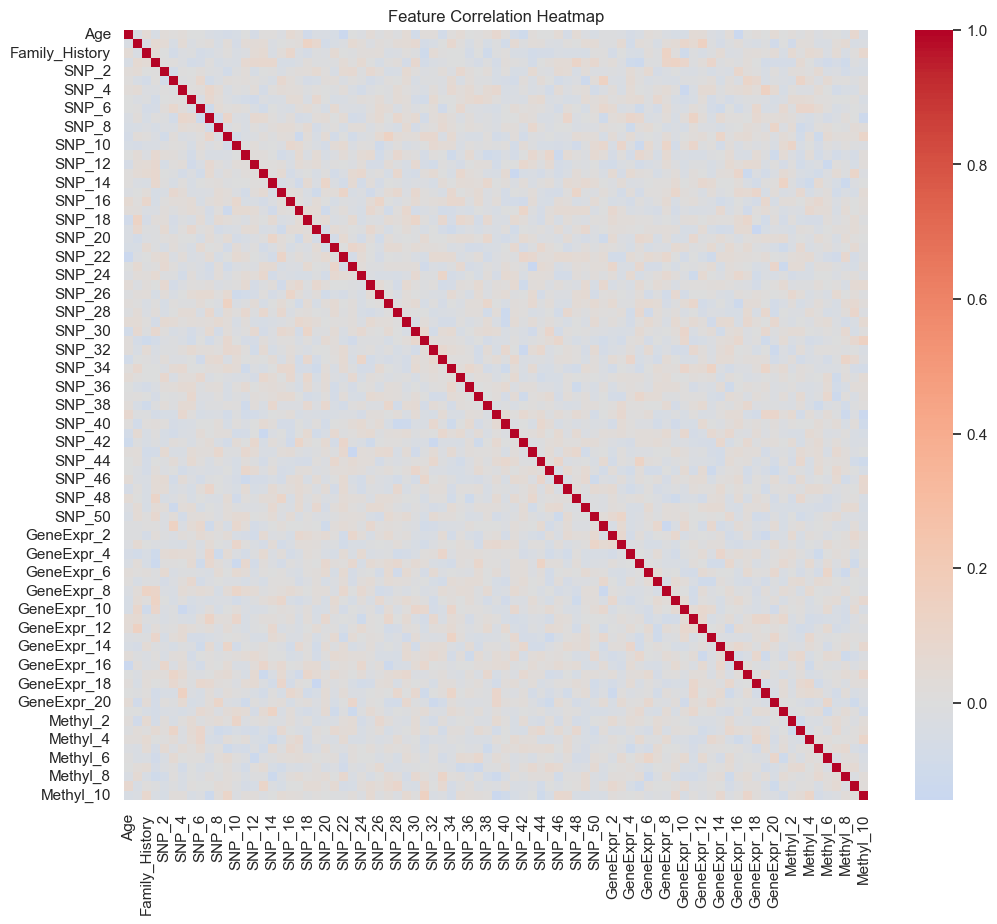

In [6]:
#display correlation heatmap
plt.figure(figsize=(12,10))
corr = X.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

Shape after Variance Threshold: (500, 83)

--- Running L1 Regularization (Lasso) ---
L1 selected 23 features.


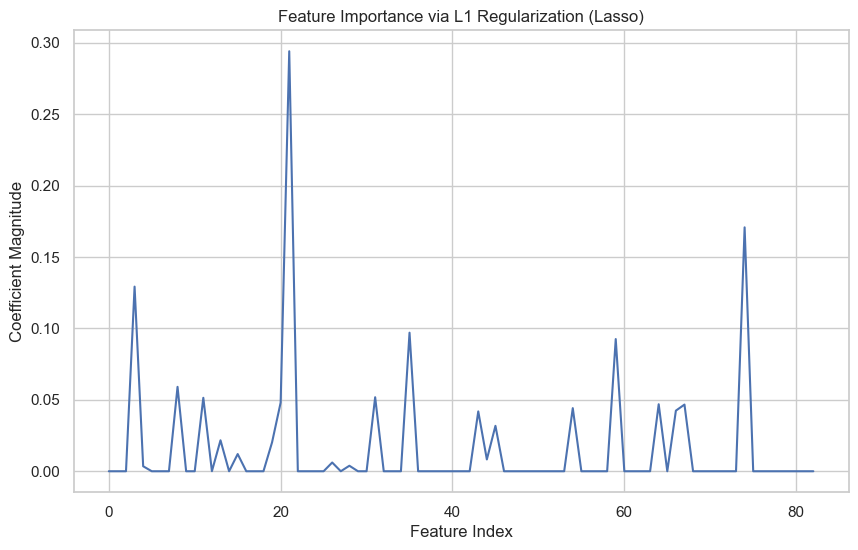


--- Running RFE with Random Forest ---
RFE selected top 20 features: ['GeneExpr_1', 'GeneExpr_2', 'GeneExpr_3', 'GeneExpr_6', 'GeneExpr_7', 'GeneExpr_8', 'GeneExpr_11', 'GeneExpr_12', 'GeneExpr_13', 'GeneExpr_14', 'GeneExpr_15', 'GeneExpr_17', 'GeneExpr_18', 'GeneExpr_19', 'GeneExpr_20', 'Methyl_1', 'Methyl_2', 'Methyl_6', 'Methyl_8', 'Methyl_10']

Final Selected Feature Count: 37
['GeneExpr_6', 'SNP_10', 'GeneExpr_12', 'GeneExpr_15', 'GeneExpr_13', 'SNP_18', 'SNP_13', 'SNP_33', 'GeneExpr_18', 'GeneExpr_3', 'GeneExpr_8', 'GeneExpr_20', 'GeneExpr_17', 'SNP_24', 'SNP_1', 'Methyl_2', 'SNP_41', 'SNP_6', 'GeneExpr_14', 'SNP_19', 'GeneExpr_19', 'Methyl_8', 'Methyl_1', 'Methyl_10', 'SNP_42', 'GeneExpr_1', 'SNP_26', 'Methyl_6', 'SNP_43', 'SNP_29', 'SNP_11', 'GeneExpr_11', 'SNP_17', 'GeneExpr_2', 'SNP_2', 'SNP_9', 'GeneExpr_7']


In [7]:

# VARIANCE THRESHOLD (Sanity Check)
# Remove features that have 0 variance (same value for everyone)
# This is a prerequisite before advanced selection.
selector = VarianceThreshold(threshold=0)
X_reduced = selector.fit_transform(X)

# Keep track of column names
features_kept = X.columns[selector.get_support()]
X = pd.DataFrame(X_reduced, columns=features_kept)

print(f"Shape after Variance Threshold: {X.shape}")

# Scale the data (Required for L1 Regularization)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split Data (Stratified because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


# L1 REGULARIZATION (Lasso)
# L1 penalty forces weak feature coefficients to zero.
print("\n--- Running L1 Regularization (Lasso) ---")

# 'liblinear' solver supports L1 penalty
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_train, y_train)

# Identify features with non-zero coefficients
lasso_coefs = abs(lasso.coef_[0])
selected_l1_mask = lasso_coefs > 0
selected_l1_features = X_train.columns[selected_l1_mask]

print(f"L1 selected {len(selected_l1_features)} features.")

# Visualization of Coefficients (Great for the report)
plt.figure(figsize=(10, 6))
plt.plot(range(len(lasso_coefs)), lasso_coefs)
plt.title("Feature Importance via L1 Regularization (Lasso)")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Magnitude")
plt.show()


# RECURSIVE FEATURE ELIMINATION (RFE)
# Uses a Random Forest to recursively prune the weakest features.
print("\n--- Running RFE with Random Forest ---")

rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Select top 20 features (Arbitrary choice, or can be tuned)
rfe = RFE(estimator=rf, n_features_to_select=20, step=1)
rfe.fit(X_train, y_train)

selected_rfe_features = X_train.columns[rfe.support_]

print(f"RFE selected top 20 features: {list(selected_rfe_features)}")


# FINAL FEATURE SET SELECTION
# Strategy: Union (Keep features selected by EITHER method) for maximum information,
# or Intersection (Keep features selected by BOTH) for stricter selection.

# Let's use Union for now to not lose signal
final_features = list(set(selected_l1_features) | set(selected_rfe_features))

print(f"\nFinal Selected Feature Count: {len(final_features)}")
print(final_features)

# Update X_train and X_test to only use these features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

Training models on 37 selected features...
------------------------------------------------------------
Logistic Regression trained. Accuracy: 0.4800 | F1-Score: 0.6286
SVM trained. Accuracy: 0.5900 | F1-Score: 0.7389
Random Forest trained. Accuracy: 0.7800 | F1-Score: 0.8764
Gradient Boosting trained. Accuracy: 0.7700 | F1-Score: 0.8686

--- Model Performance Summary ---


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
Random Forest,0.780000,0.780000,1.000000,0.876404,0.404138
Gradient Boosting,0.770000,0.783505,0.974359,0.868571,0.510490
SVM,0.590000,0.734177,0.743590,0.738854,0.315268
Logistic Regression,0.480000,0.709677,0.564103,0.628571,0.329254


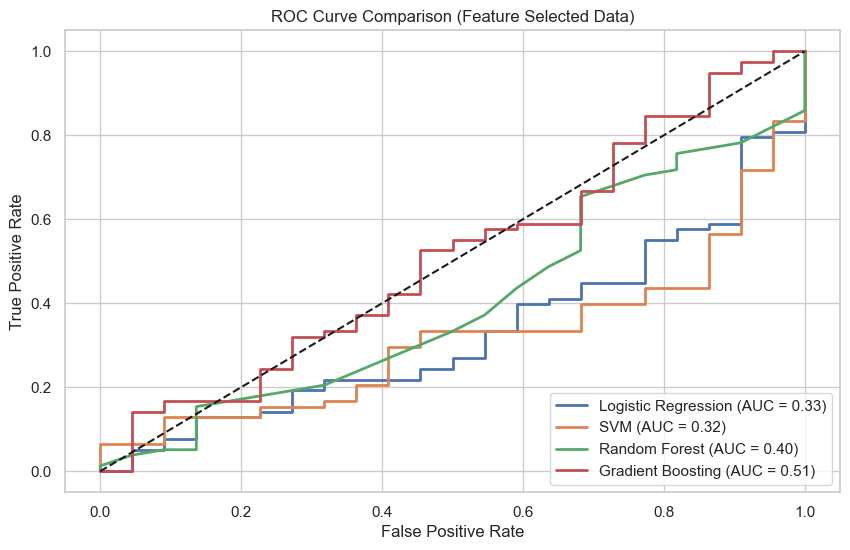

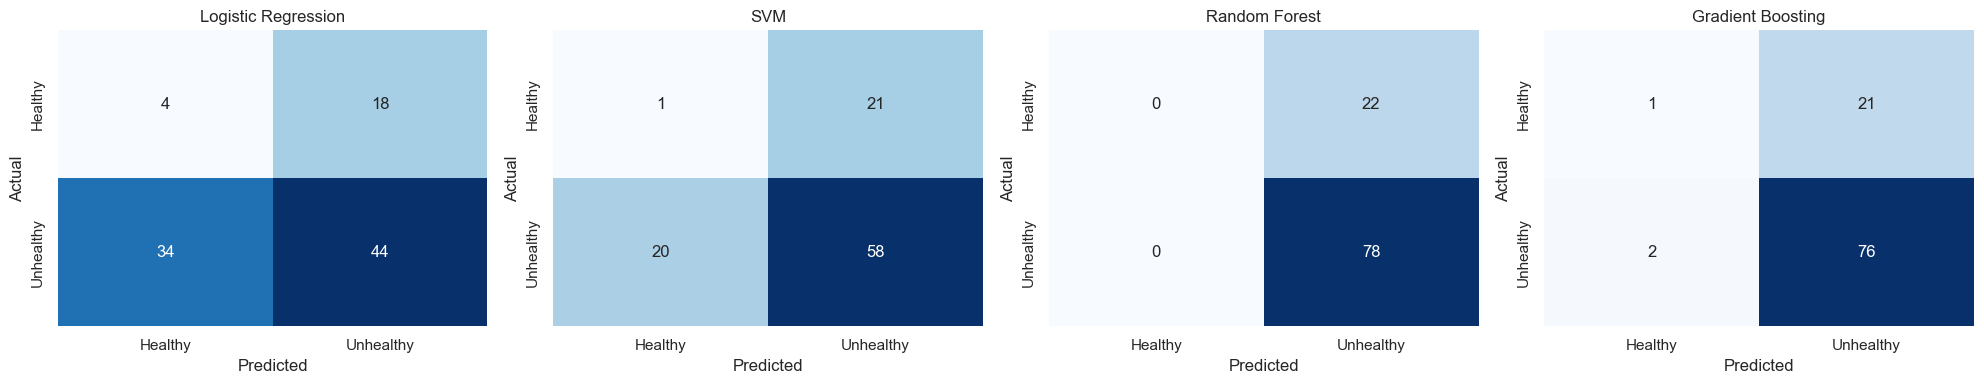

In [8]:

# Model Training & Evaluation (Multi-Model Comparison)

# 3.1 Additional Imports for Models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

# Initialize the 4 Models
# We use class_weight='balanced' where available to handle the 78/22 class imbalance automatically
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Dataframes to store results
results_list = []
roc_data = {}

print(f"Training models on {len(final_features)} selected features...")
print("-" * 60)

# Training Loop
for name, model in models.items():
    # Train on the selected feature set from Phase 2
    model.fit(X_train_final, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]  # Probabilities for ROC-AUC
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) # Critical for medical diagnosis
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })
    
    # Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, auc)
    
    print(f"{name} trained. Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")

# Display Comparative Results Table
results_df = pd.DataFrame(results_list).set_index("Model")
results_df = results_df.sort_values(by="F1-Score", ascending=False)

print("\n--- Model Performance Summary ---")
display(results_df.style.background_gradient(cmap="Blues"))


# Visualization: ROC Curves & Confusion Matrices

plt.figure(figsize=(10, 6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Feature Selected Data)')
plt.legend(loc="lower right")
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for ax, name in zip(axes, models.keys()):
    model = models[name]
    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Healthy', 'Unhealthy'])
    ax.set_yticklabels(['Healthy', 'Unhealthy'])

plt.tight_layout()
plt.show()

Original Shape: (500, 86)

Class Distribution (Original):
Diagnosis
Bipolar Disorder    136
Alzheimer's         128
Schizophrenia       127
Healthy             109
Name: count, dtype: int64


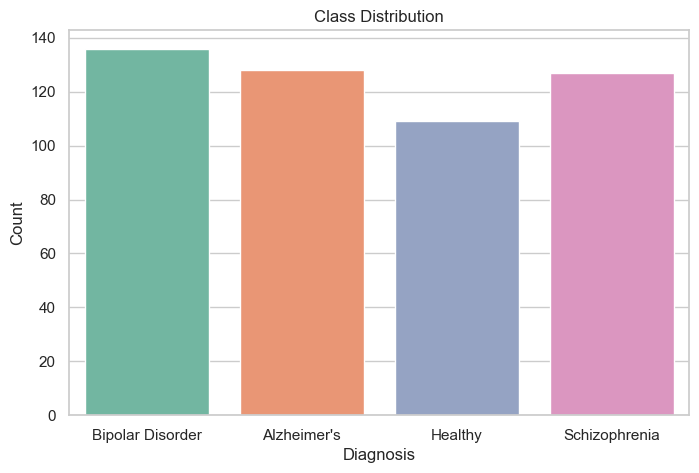

In [9]:
# Repeating check of data distribution and missing values by visualization
print(f"Original Shape: {df.shape}")
print("\nClass Distribution (Original):")
print(df['Diagnosis'].value_counts())
plt.figure(figsize=(8,5))
sns.countplot(x='Diagnosis', data=df, palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()  

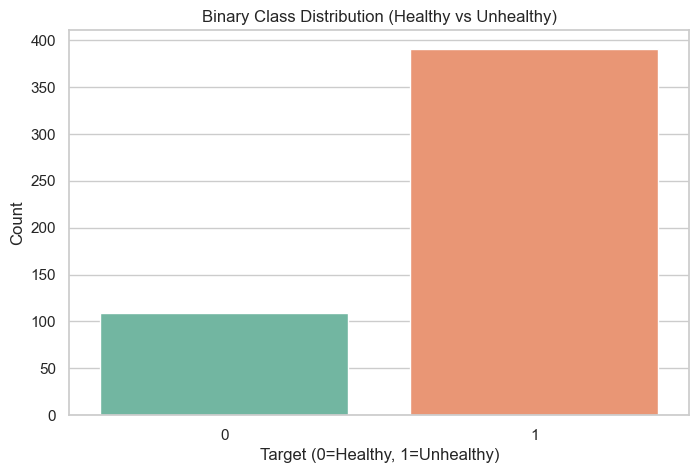

In [10]:
# convert data into healthy and unhealthy categories again for new model trainings to see results
binary_map = {
    'Healthy': 0,
    'Bipolar Disorder': 1,
    "Alzheimer's": 1,
    'Schizophrenia': 1
}   

df['Target'] = df['Diagnosis'].map(binary_map)  

#new class distribution plot
plt.figure(figsize=(8,5))
sns.countplot(x='Target', data=df, palette='Set2')
plt.title('Binary Class Distribution (Healthy vs Unhealthy)')
plt.xlabel('Target (0=Healthy, 1=Unhealthy)')
plt.ylabel('Count')
plt.show()  


Resampled Class Distribution:


  File "C:\Users\orobo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\orobo\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\orobo\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\orobo\anaconda3\Lib\subprocess.

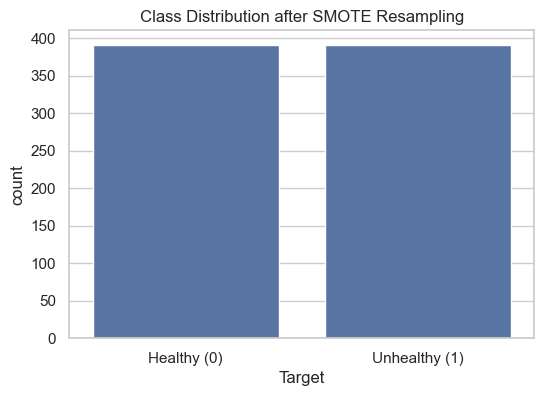

In [11]:
# apply SMOTE for balancing the new binary dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("\nResampled Class Distribution:")
# visualize the resampled class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_res)
plt.title('Class Distribution after SMOTE Resampling')
plt.xticks(ticks=[0,1], labels=['Healthy (0)', 'Unhealthy (1)'])
plt.show()

Shape after Variance Threshold: (782, 83)

--- Running L1 Regularization (Lasso) ---
L1 selected 50 features.


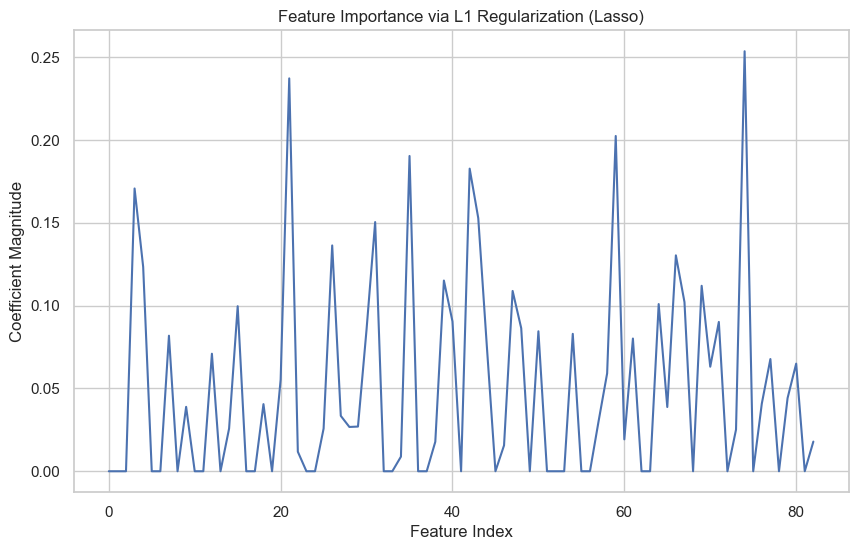


--- Running RFE with Random Forest ---
RFE selected top 37 features: ['Age', 'Family_History', 'SNP_1', 'SNP_13', 'SNP_19', 'SNP_23', 'SNP_26', 'SNP_29', 'SNP_33', 'SNP_37', 'SNP_38', 'SNP_40', 'SNP_41', 'SNP_42', 'SNP_46', 'SNP_48', 'SNP_49', 'GeneExpr_2', 'GeneExpr_3', 'GeneExpr_4', 'GeneExpr_5', 'GeneExpr_6', 'GeneExpr_7', 'GeneExpr_9', 'GeneExpr_11', 'GeneExpr_12', 'GeneExpr_14', 'GeneExpr_16', 'GeneExpr_18', 'GeneExpr_20', 'Methyl_1', 'Methyl_2', 'Methyl_3', 'Methyl_5', 'Methyl_7', 'Methyl_8', 'Methyl_9']

Final Selected Feature Count: 60
['SNP_45', 'SNP_10', 'GeneExpr_12', 'Methyl_3', 'SNP_18', 'SNP_13', 'SNP_33', 'SNP_40', 'GeneExpr_3', 'GeneExpr_8', 'GeneExpr_16', 'SNP_32', 'GeneExpr_20', 'SNP_1', 'SNP_19', 'GeneExpr_19', 'SNP_48', 'Methyl_5', 'Methyl_8', 'GeneExpr_5', 'Methyl_7', 'SNP_25', 'SNP_26', 'SNP_28', 'SNP_46', 'GeneExpr_2', 'SNP_38', 'Age', 'GeneExpr_6', 'SNP_12', 'GeneExpr_15', 'GeneExpr_13', 'GeneExpr_18', 'SNP_20', 'GeneExpr_4', 'Methyl_4', 'Family_History', 'Gene

In [12]:
# feature selection and model training with the new balanced dataset
# VARIANCE THRESHOLD (Sanity Check)
# Remove features that have 0 variance (same value for everyone)
# This is a prerequisite before advanced selection.
selector = VarianceThreshold(threshold=0)
X_reduced = selector.fit_transform(X_res)               
# Keep track of column names
features_kept = X.columns[selector.get_support()]
X_res = pd.DataFrame(X_reduced, columns=features_kept)  
print(f"Shape after Variance Threshold: {X_res.shape}")
# Scale the data (Required for L1 Regularization)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_res), columns=X_res.columns)
# Split Data (Stratified because of imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_res, test_size=0.2, stratify=y_res,
    random_state=42
)

# L1 REGULARIZATION (Lasso)
# L1 penalty forces weak feature coefficients to zero.
print("\n--- Running L1 Regularization (Lasso) ---")
# 'liblinear' solver supports L1 penalty
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso.fit(X_train, y_train)

# Identify features with non-zero coefficients
lasso_coefs = abs(lasso.coef_[0])                                       
selected_l1_mask = lasso_coefs > 0
selected_l1_features = X_train.columns[selected_l1_mask]
print(f"L1 selected {len(selected_l1_features)} features.")
# Visualization of Coefficients (Great for the report)          
plt.figure(figsize=(10, 6))
plt.plot(range(len(lasso_coefs)), lasso_coefs)
plt.title("Feature Importance via L1 Regularization (Lasso)")
plt.xlabel("Feature Index") 
plt.ylabel("Coefficient Magnitude")
plt.show()

# RECURSIVE FEATURE ELIMINATION (RFE)
# Uses a Random Forest to recursively prune the weakest features.
print("\n--- Running RFE with Random Forest ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)      
# Select top 37 features (Arbitrary choice, or can be tuned)
rfe = RFE(estimator=rf, n_features_to_select=37, step=1)
rfe.fit(X_train, y_train)
selected_rfe_features = X_train.columns[rfe.support_]
print(f"RFE selected top 37 features: {list(selected_rfe_features)}")


# FINAL FEATURE SET SELECTION
# Strategy: Union (Keep features selected by EITHER method) for maximum information,
# or Intersection (Keep features selected by BOTH) for stricter selection.
# Let's use Union for now to not lose signal
final_features = list(set(selected_l1_features) | set(selected_rfe_features))
print(f"\nFinal Selected Feature Count: {len(final_features)}")
print(final_features)
# Update X_train and X_test to only use these features
X_train_final = X_train[final_features]
X_test_final = X_test[final_features]   

In [13]:

# Model Training & Evaluation (Multi-Model Comparison)
# Additional Imports for Models
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

# Initialize the 4 Models
# We use class_weight='balanced' where available to handle the 78/22 class imbalance automatically
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}
# Dataframes to store results
results_list = []
roc_data = {}
print(f"Training models on {len(final_features)} selected features...")
print("-" * 60)
# 3.3 Training Loop
for name, model in models.items():  
    # Train on the selected feature set from Phase 2
    model.fit(X_train_final, y_train)
    # Predictions
    y_pred = model.predict(X_test_final)
    y_prob = model.predict_proba(X_test_final)[:, 1]  # Probabilities for ROC-AUC
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred) # Critical for medical diagnosis
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    # Store results
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })
    # Store ROC curve data
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_data[name] = (fpr, tpr, auc)
    print(f"{name} trained. Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")
    
# Display Comparative Results Table
results_df = pd.DataFrame(results_list).set_index("Model")
results_df = results_df.sort_values(by="F1-Score", ascending=False)
print("\n--- Model Performance Summary ---")
display(results_df.style.background_gradient(cmap="Blues")) 

Training models on 60 selected features...
------------------------------------------------------------
Logistic Regression trained. Accuracy: 0.6624 | F1-Score: 0.6667
SVM trained. Accuracy: 0.9172 | F1-Score: 0.9212
Random Forest trained. Accuracy: 0.8981 | F1-Score: 0.9059
Gradient Boosting trained. Accuracy: 0.9108 | F1-Score: 0.9157

--- Model Performance Summary ---


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
SVM,0.917197,0.873563,0.974359,0.921212,0.961214
Gradient Boosting,0.910828,0.863636,0.974359,0.915663,0.913664
Random Forest,0.898089,0.836957,0.987179,0.905882,0.921211
Logistic Regression,0.662420,0.654321,0.679487,0.666667,0.747485


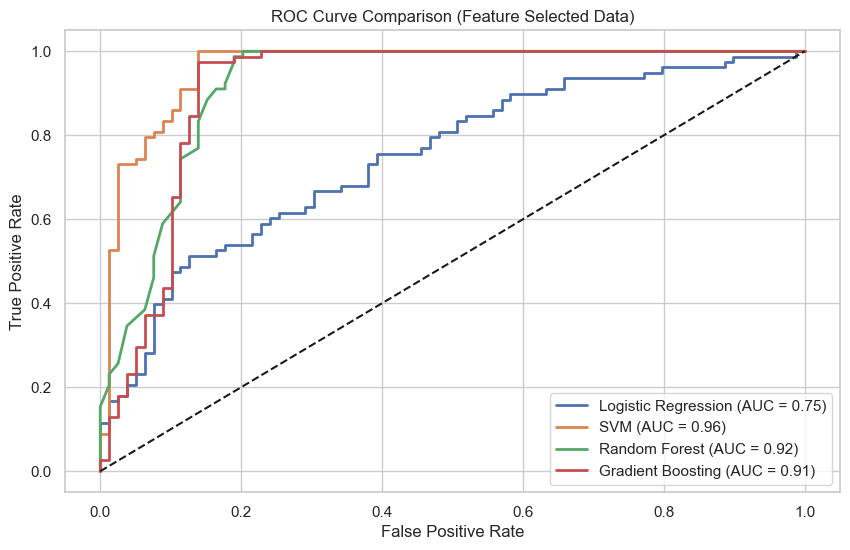

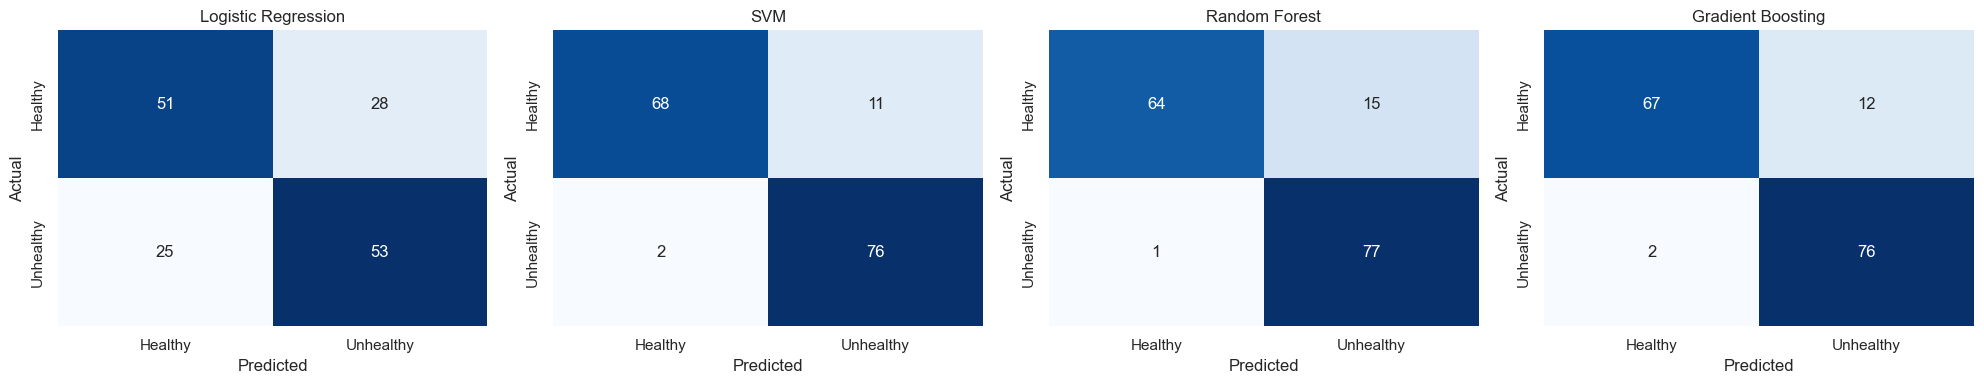

Best Accuracy Model: SVM
Best F1-Score Model: SVM


In [14]:
# test model performance after balancing the dataset with SMOTE
# on Accuracy, F1-Score and Recall, AUC
# Visualization: ROC Curves & Confusion Matrices
# Plot ROC Curves for all models                            
plt.figure(figsize=(10, 6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Feature Selected Data)')
plt.legend(loc="lower right")
plt.show()
# Plot Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for ax, name in zip(axes, models.keys()):
    model = models[name]
    y_pred = model.predict(X_test_final)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Healthy', 'Unhealthy'])
    ax.set_yticklabels(['Healthy', 'Unhealthy'])
plt.tight_layout()
plt.show()  

# best model per metrics
best_accuracy_model = results_df['Accuracy'].idxmax()
best_f1_model = results_df['F1-Score'].idxmax()
best_auc_model = results_df['AUC'].idxmax() 
print(f"Best Accuracy Model: {best_accuracy_model}")
print(f"Best F1-Score Model: {best_f1_model}")      

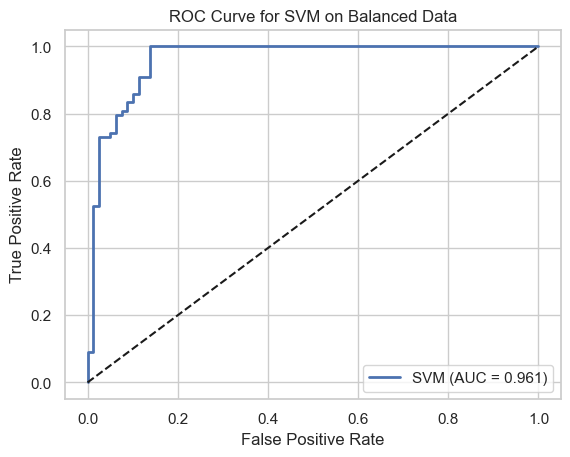

In [15]:
#ROC AUC curve for SVM
svm_model = models["SVM"]
y_prob = svm_model.predict_proba(X_test_final)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_val = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc_val:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM on Balanced Data')
plt.legend(loc='lower right')
plt.show()

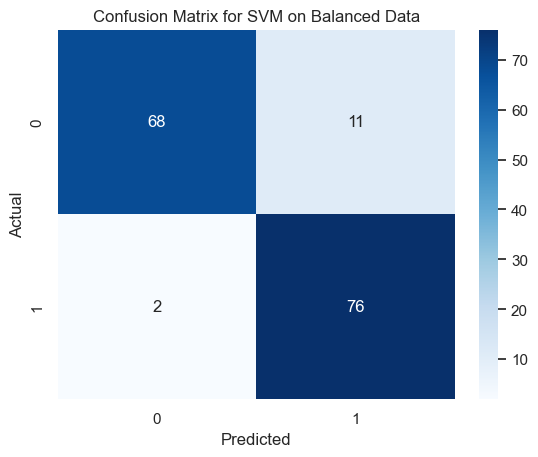

In [16]:
#Confusion matrix for SVM
y_pred = svm_model.predict(X_test_final)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for SVM on Balanced Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

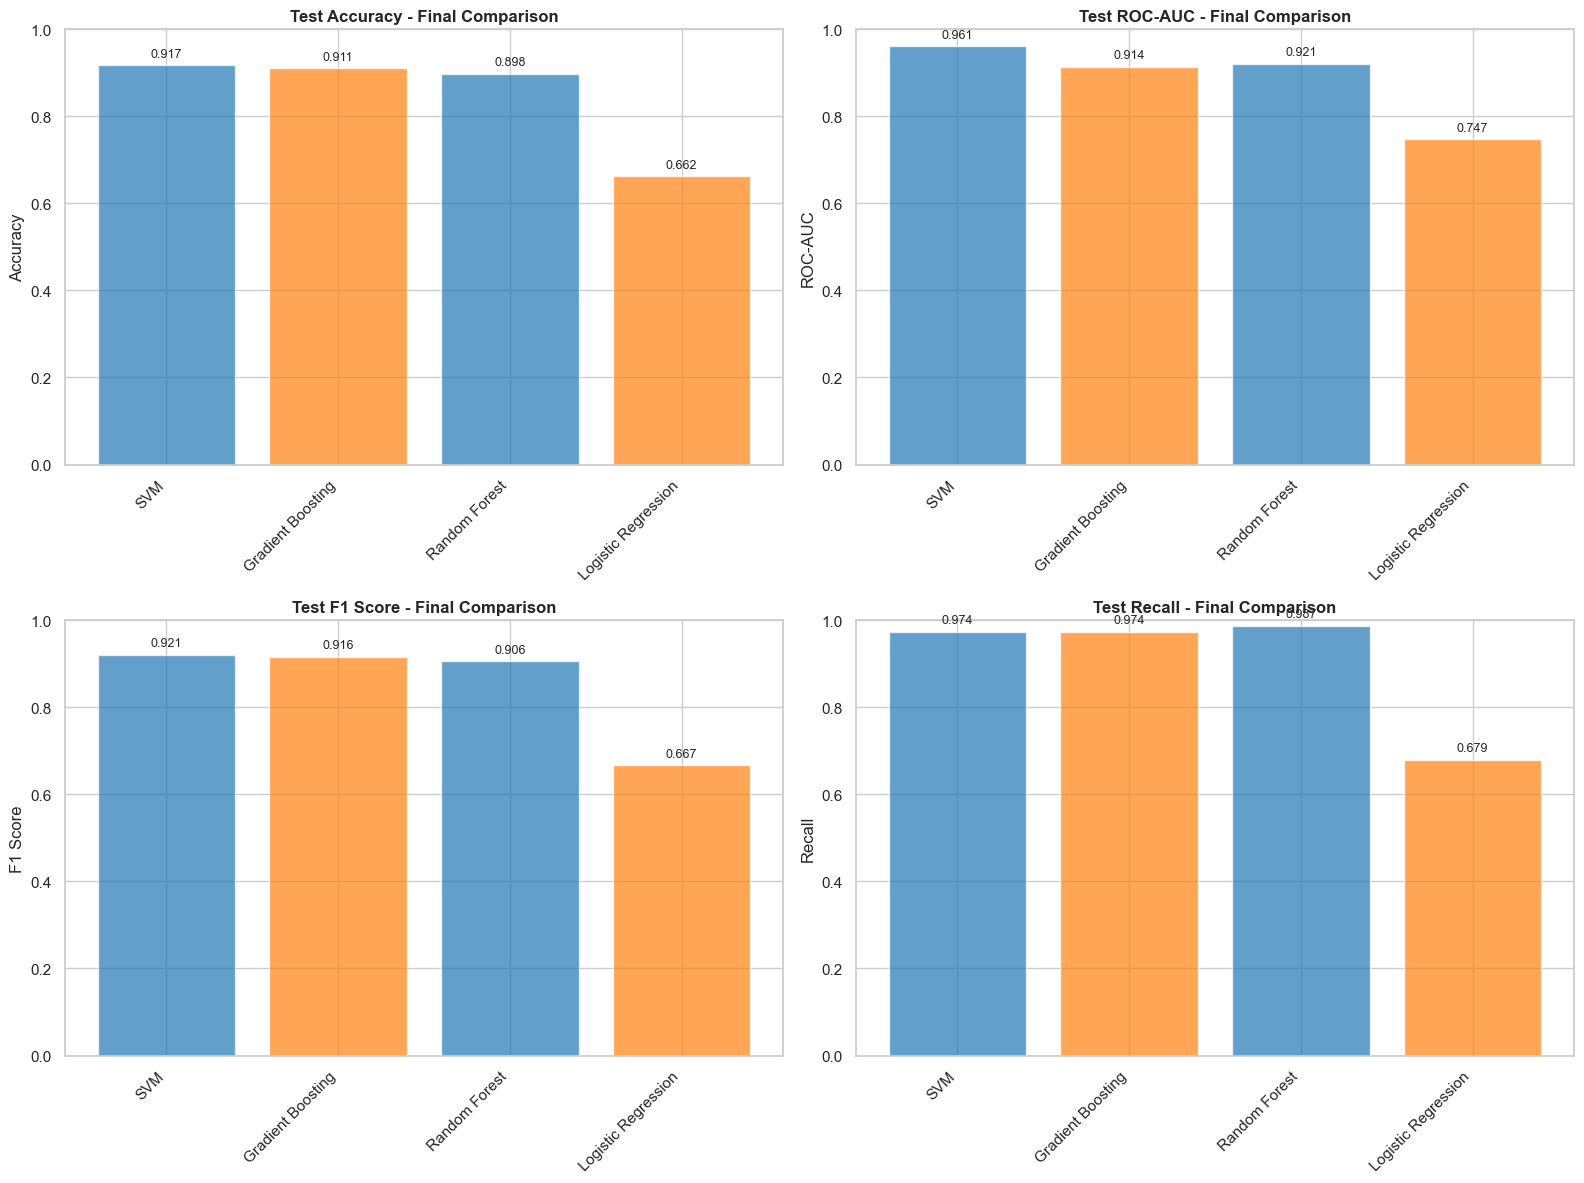

In [17]:
import numpy as np

# Prepare results for plotting
final_comparison_results = {
    "Test_Accuracy": results_df["Accuracy"].values,
    "Test_ROC_AUC": results_df["AUC"].values,
    "Test_F1": results_df["F1-Score"].values,
    "Test_Recall": results_df["Recall"].values
}
model_names = results_df.index.tolist()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_pos = np.arange(len(model_names))

# Test Accuracy
axes[0, 0].bar(x_pos, final_comparison_results["Test_Accuracy"], color=["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"], alpha=0.7)
axes[0, 0].set_title("Test Accuracy - Final Comparison", fontsize=12, fontweight="bold")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=45, ha="right")
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(final_comparison_results["Test_Accuracy"]):
    axes[0, 0].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

# Test ROC-AUC
axes[0, 1].bar(x_pos, final_comparison_results["Test_ROC_AUC"], color=["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"], alpha=0.7)
axes[0, 1].set_title("Test ROC-AUC - Final Comparison", fontsize=12, fontweight="bold")
axes[0, 1].set_ylabel("ROC-AUC")
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names, rotation=45, ha="right")
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(final_comparison_results["Test_ROC_AUC"]):
    axes[0, 1].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

# Test F1 Score
axes[1, 0].bar(x_pos, final_comparison_results["Test_F1"], color=["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"], alpha=0.7)
axes[1, 0].set_title("Test F1 Score - Final Comparison", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("F1 Score")
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names, rotation=45, ha="right")
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(final_comparison_results["Test_F1"]):
    axes[1, 0].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

# Test Recall
axes[1, 1].bar(x_pos, final_comparison_results["Test_Recall"], color=["#1f77b4", "#ff7f0e", "#1f77b4", "#ff7f0e"], alpha=0.7)
axes[1, 1].set_title("Test Recall - Final Comparison", fontsize=12, fontweight="bold")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=45, ha="right")
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(final_comparison_results["Test_Recall"]):
    axes[1, 1].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

plt.tight_layout()
#plt.savefig("images/Final_coparison_Plots.png", dpi=1200, bbox_inches="tight") #SOS
plt.show()